In [3]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import igraph as ig
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import namedtuple, defaultdict

from robustness import logger
logger.setLevel('INFO')

from robustness import NETWORKS_DIR
from robustness.mpl_settings_v3 import *
from robustness.planar import create_proximity_graph
from robustness.auxiliary import (
    getLinearReg, 
    get_base_network_name, 
    powerlaw, 
    load_delta_data, 
    read_data_file
)
from robustness.plot_auxiliary import (
    letters,
    attack_dict,
    fig_dir, 
    load_delta,
    load_deltas,
    load_dataframe, 
    get_critical_measures,
    getPeaks,
    compute_fc_v2,
    get_rc_values,
    get_l_cutoff
)

%matplotlib inline

net_type = 'DT'
param = 'param'

net_dir = os.path.join('..', 'networks', net_type)

marker_dict = {'num': 'o', 'Nsec': 's', 'varSgcc': '^', 'Sgcc': '*'}
color_dict = {'num': 'C0', 'Nsec': 'C1', 'varSgcc': 'C2', 'Sgcc': 'C3'}
linestyle_dict = {'num': '--', 'Nsec': '-.', 'varSgcc': ':', 'Sgcc': ':'}
measures_dict = {'num': r'$\langle s \rangle$', 'Nsec': r'$S_2 L^2$', 'varSgcc': r'$\chi$', 'Sgcc': r'$N_1$'}
line_colors = {'num': 'k', 'Nsec': 'grey', 'varSgcc': 'brown', 'Sgcc': 'C8'}

In [ ]:
def cross(rc_values, params, ax, alpha, sizes, legend=False):
    colormap = sns.cubehelix_palette(
        len(sizes), start=2, rot=0.3, light=0.8, dark=0.1
    )
    ## Standard
    X = np.sqrt(sizes)
    ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

    ax.set_xlabel(r'$q/L^{\alpha}$')
    ax.set_ylabel(r'$f^{\mathrm{B}q}_{\Delta}(L)-f^{\mathrm{B}}_{\Delta}(L)$')

    xlim, ylim = params[alpha]
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    print(f'alpha = {alpha}')
    for i, size in enumerate(sizes):
        mask = ~np.isnan(rc_values[size][1:])
        L = np.sqrt(size)
        X = l_values[mask]*L**(-alpha)
        Y = rc_values[size][1:][mask] - rc_values[size][0]
        mask = X>0
        X = X[mask]
        Y = Y[mask]
        qmin = int(xlim[0]*L**alpha)
        qmax = int(xlim[1]*L**alpha)
        mask = (X>=xlim[0]) & (X <= xlim[1])
        try:
            mask[np.where(mask)[0][0]-1] = True
            mask[np.where(mask)[0][-1]+1] = True
        except Exception:
            pass
        X = X[mask]
        Y = Y[mask]
        ax.plot(
            X, Y, '-', marker=markers[i], markersize=8,
            label=r'${{{}}}$'.format(int(L))
            #color=colormap[i]
        )

        print(size, int(L), qmin, qmax, qmax-qmin, len(X), sep='\t', end='\t')
        print(X*L**alpha)
    if legend:
        ax.legend()
    ax.text(0.1, 0.1, r'$\alpha={{{}}}$'.format(alpha), fontsize=32, transform=ax.transAxes)
    
Params = namedtuple('Params', ['xlim', 'ylim'])

In [75]:
base_attack = 'Btw'
net_type = 'DT'
param = 'param'
min_nseeds = 10000
nseeds = None
threshold = 0.01
sizes = [
    1024, 2048, 4096, 
    8192, 16384, 32768, 65536, 131072
]

rc_values, rc_values_std = get_rc_values(
    net_type, param, base_attack, sizes, 
    nseeds=nseeds, min_nseeds=min_nseeds
)
l_cutoff = get_l_cutoff(
    net_type, param,  base_attack, sizes, 
    threshold=threshold, rc_values=rc_values, 
    nseeds=nseeds, min_nseeds=min_nseeds
)
l_cutoff

{1024: 16, 2048: 22, 4096: 31, 8192: 42, 16384: 57}

In [76]:
lmax = 200
l_values = np.arange(1, lmax+1)
_rc_values = {
    size: np.array([rc_values[size][base_attack]] + [np.nan]*lmax)
    for size in sizes
}

_rc_values_std = {
    size: np.array([rc_values_std[size][base_attack]] + [np.nan]*lmax) 
    for size in sizes
}

for size in sizes:
    for l in l_values:
        attack = f'{base_attack}_cutoff{l}'
        if attack in rc_values[size]:
            _rc_values[size][l] = rc_values[size][attack]
            _rc_values_std[size][l] = rc_values_std[size][attack]

alpha = 0.92
16384	128	11	14	3	0	[]
32768	181	15	20	5	2	[ 8. 16.]
65536	256	21	27	6	0	[]
131072	362	29	38	9	0	[]
alpha = 0.95
16384	128	11	13	2	0	[]
32768	181	16	18	2	0	[]
65536	256	22	26	4	0	[]
131072	362	31	36	5	0	[]
alpha = 1
16384	128	12	14	2	0	[]
32768	181	18	20	2	0	[]
65536	256	25	28	3	0	[]
131072	362	36	40	4	0	[]


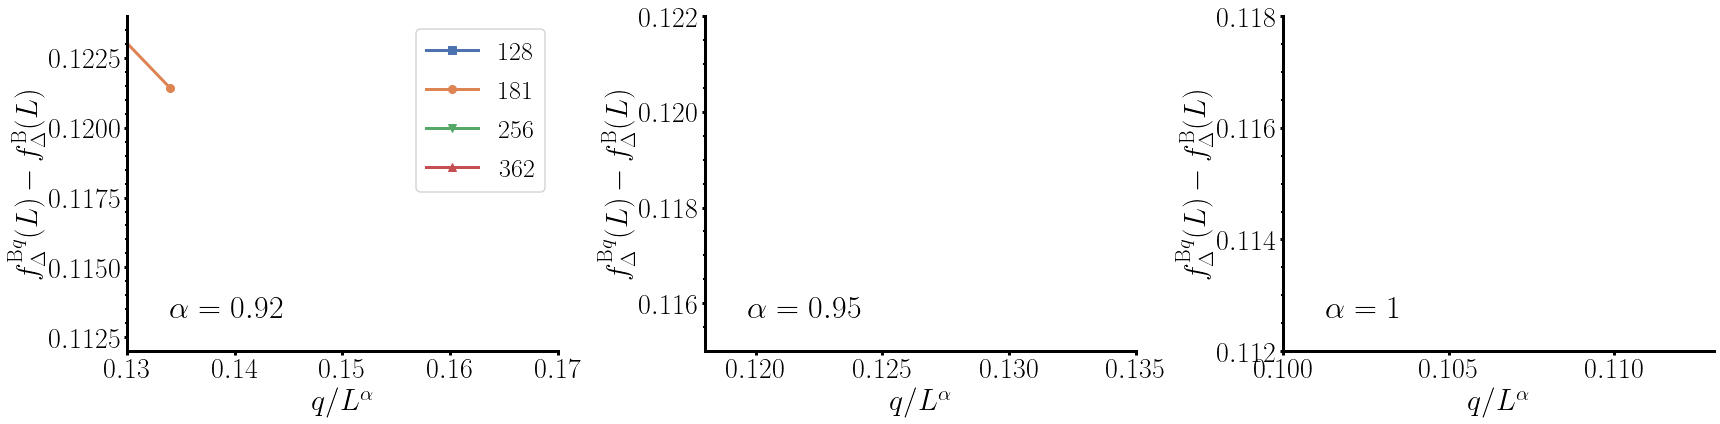

In [77]:
params_dict = {
    0.92: Params((0.13, 0.17), (0.112, 0.124)),
    0.95: Params((0.118, 0.135), (0.115, 0.122)),
    1   : Params((0.10, 0.113), (0.112, 0.118))
}
sizes = list(rc_values.keys())[-4:]
alphas = [0.92, 0.95, 1]
ncols = len(alphas)
nrows = 1
fig, axes = plt.subplots(figsize=(8*ncols,6*nrows), ncols=ncols, nrows=nrows)
for i, alpha in enumerate(alphas):
    ax = axes[i]
    legend = i==0
    cross(_rc_values, params_dict, ax, alpha, sizes, legend=legend)
sns.despine()
plt.tight_layout()
plt.show()

alpha = 0.92
16384	128	6	21	15	3	[ 3. 16. 56.]
32768	181	9	29	20	2	[ 8. 16.]
65536	256	13	41	28	2	[ 4. 16.]
131072	362	18	56	38	0	[]
alpha = 0.95
16384	128	5	20	15	3	[ 3. 16. 56.]
32768	181	6	27	21	3	[ 4.  8. 16.]
65536	256	9	38	29	2	[ 4. 16.]
131072	362	13	53	40	2	[ 8. 16.]
alpha = 1
16384	128	3	25	22	3	[ 3. 16. 56.]
32768	181	5	36	31	3	[ 4.  8. 16.]
65536	256	7	51	44	2	[ 4. 16.]
131072	362	10	72	62	2	[ 8. 16.]


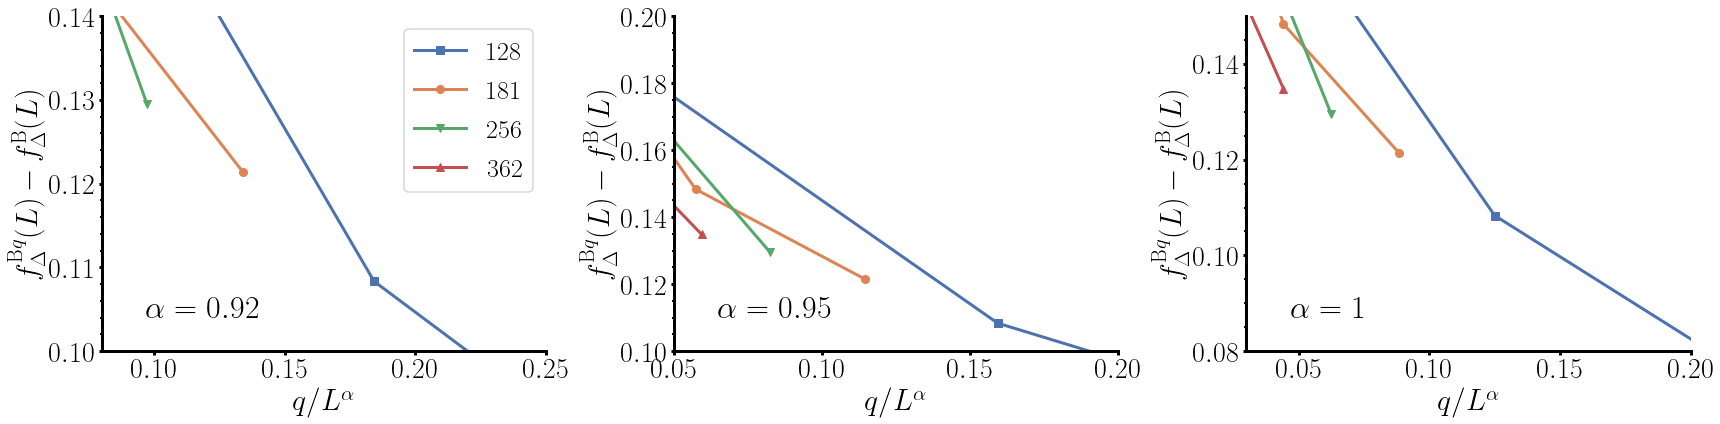

In [78]:
params_dict = {
    0.92: Params((0.08, 0.25), (0.1, 0.14)),
    0.95: Params((0.05, 0.2), (0.1, 0.2)),
    1   : Params((0.03, 0.2), (0.08, 0.15))
}
sizes = list(rc_values.keys())[-4:]
alphas = [0.92, 0.95, 1]
ncols = len(alphas)
nrows = 1
fig, axes = plt.subplots(figsize=(8*ncols,6*nrows), ncols=ncols, nrows=nrows)
for i, alpha in enumerate(alphas):
    ax = axes[i]
    legend = i==0
    cross(_rc_values, params_dict, ax, alpha, sizes, legend=legend)
sns.despine()
plt.tight_layout()
plt.show()

In [ ]:
16384: 13
32768: 19
65536: 27
131072: 37

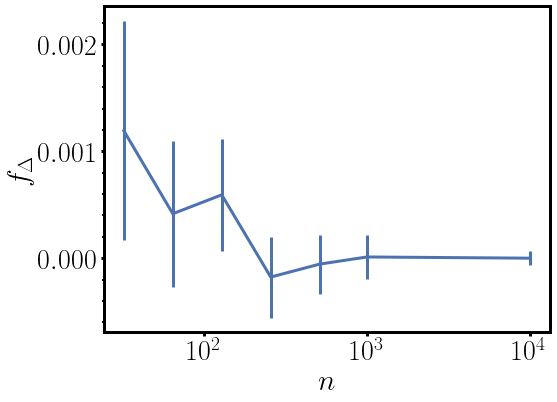

In [74]:
net_type ='DT'
param = 'param'
#size = 65536
#attack = 'Btw_cutoff27'
size = 131072
attack = 'Btw_cutoff16'
nseeds_values = [
    32, 64, 128, 256, 512, 
    1000, 10000
    #1024, 2048, 4096, 8192, 10000
]

delta_data = load_delta(
    net_type, size, param, attack, nseeds=max(nseeds_values)
)
f_delta_values = delta_data[:,0]

X = nseeds_values
Y = [f_delta_values[:nseeds].mean() for nseeds in nseeds_values]
Yerr = [f_delta_values[:nseeds].std() / np.sqrt(nseeds) for nseeds in nseeds_values]

fig, ax = plt.subplots(figsize=(8,6))
ax.set_xscale('log')
ax.set_xlabel(r'$n$')
ax.set_ylabel(r'$f_{\Delta}$')
#ax.plot(X, Y, 'o-')
ax.errorbar(X, Y-Y[-1], Yerr)
plt.show()

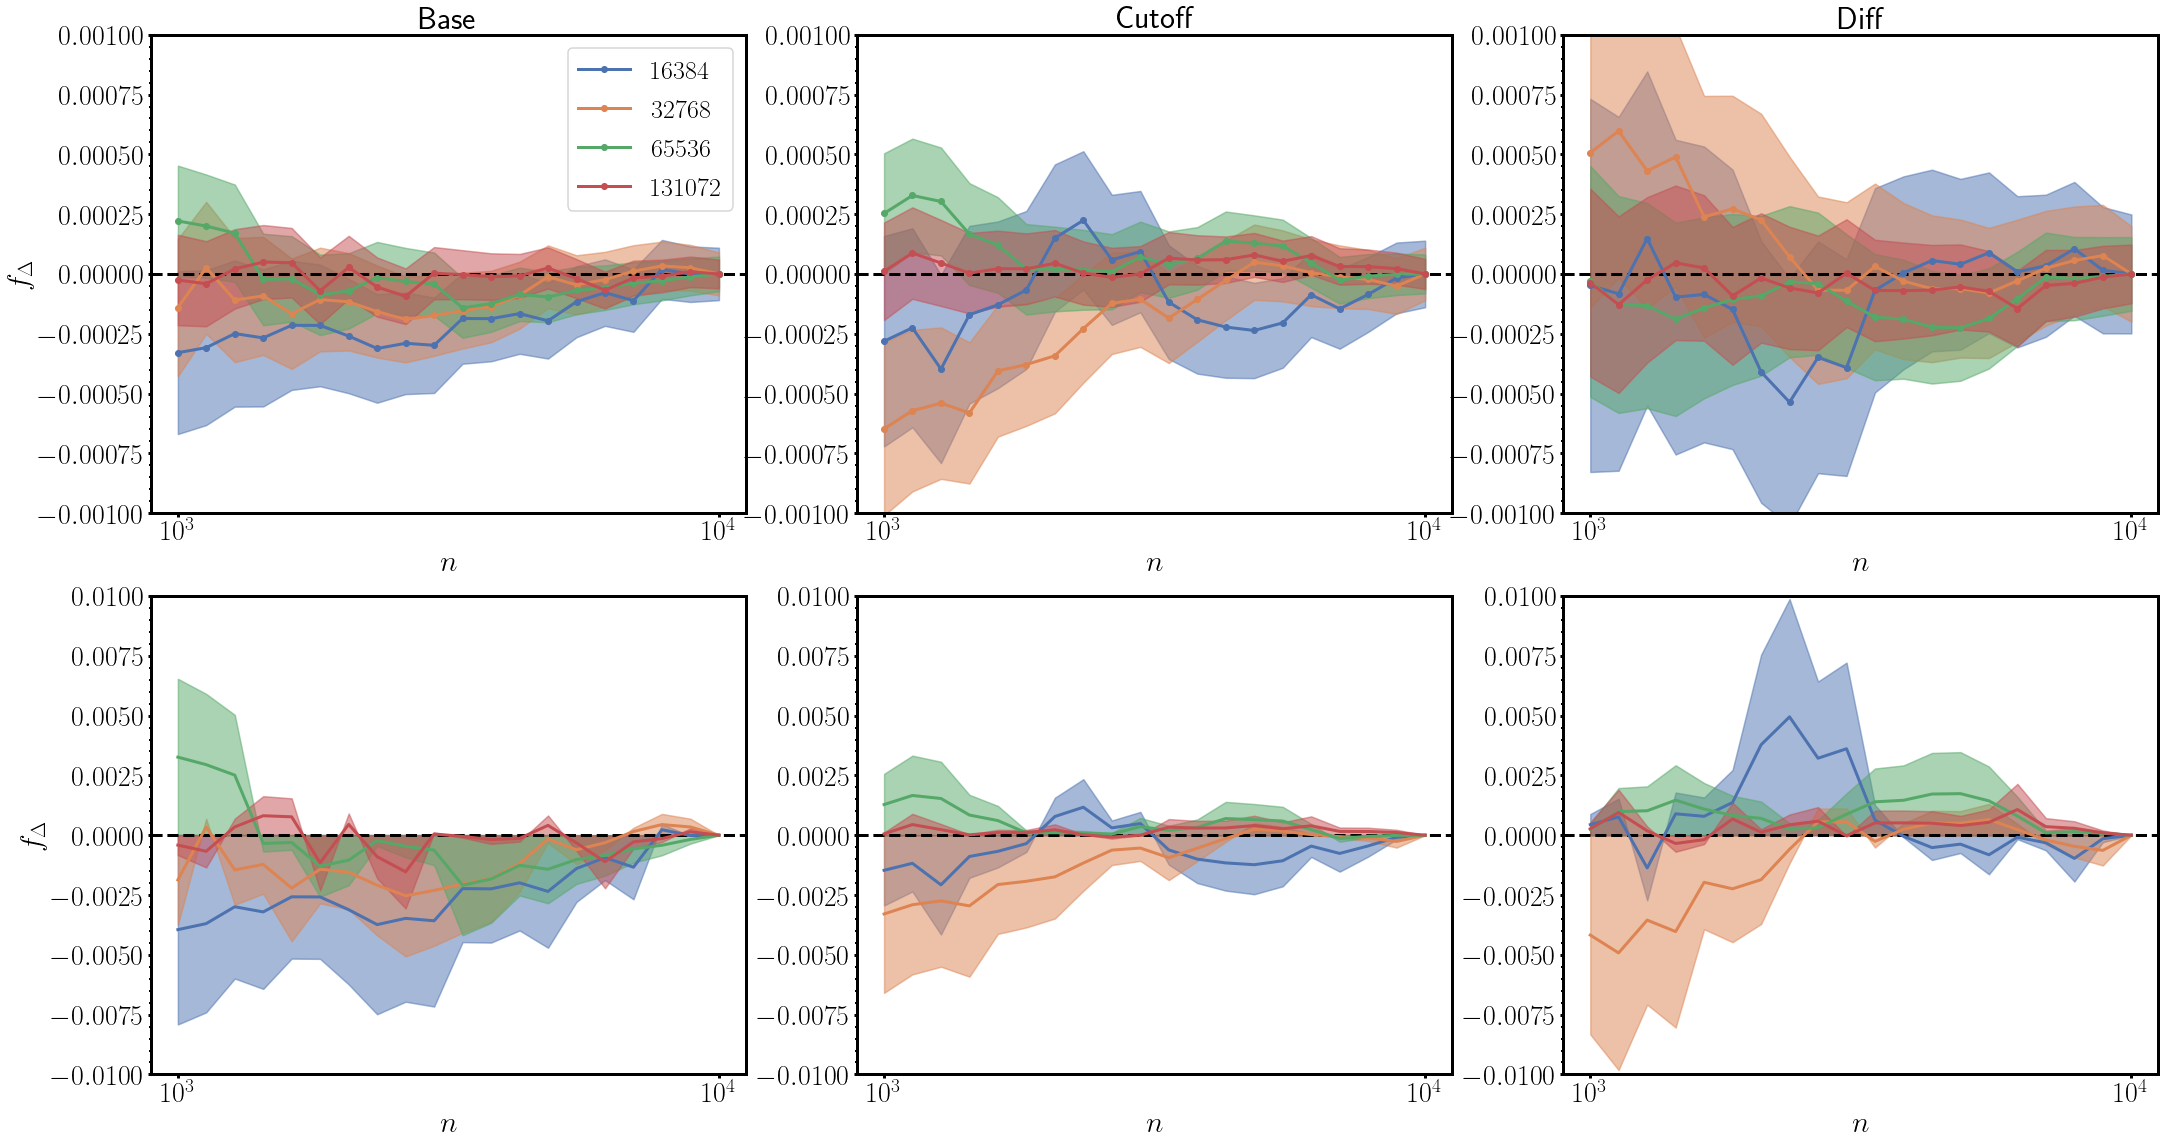

In [71]:
net_type ='DT'
param = 'param'
base_attack = 'Btw'
l = 16
cutoff_attack = f'{base_attack}_cutoff{l}'

nseeds_values = np.logspace(3, 4, 20).astype('int')
X = nseeds_values

sizes = [16384, 32768, 65536, 131072]
data = {}
for attack in [base_attack, cutoff_attack]:
    data[attack] = {}
    for size in sizes:
        
        delta_data = load_delta(
            net_type, size, param, attack, nseeds=max(nseeds_values)
        )
        f_delta_values = delta_data[:,0]
        
        Y = np.array([f_delta_values[:nseeds].mean() for nseeds in nseeds_values])
        Yerr = np.array([f_delta_values[:nseeds].std() / np.sqrt(nseeds) for nseeds in nseeds_values])
        data[attack][size] = Y, Yerr

def plot_rel(Y, Yerr, ax, i):
    Yrel = (Y-Y[-1]) / Y[-1]
    Yrel_err = Yrel * (Yerr/Y + Yerr[-1]/Yerr[-1])
    
    #ax.errorbar(X, Yrel, Yrel_err, label=label)    
    ax.plot(X, Yrel, label=label, color=f'C{i}')
    ax.fill_between(X, Yrel-Yrel_err, Yrel+Yrel_err, alpha=0.5, color=f'C{i}')
        
ncols = 3
nrows = 2
fig, axes = plt.subplots(figsize=(10*ncols,8*nrows), ncols=ncols, nrows=nrows)

for ax in axes.flatten():
    ax.set_xscale('log')
    ax.set_xlabel(r'$n$')
    ax.axhline(0, linestyle='--', color='k')
    
for ax in axes[:,0]:
    ax.set_ylabel(r'$f_{\Delta}$')
    
for ax in axes[0]:
    ax.set_ylim(-0.001, 0.001)
for ax in axes[1]:
    ax.set_ylim(-0.01, 0.01)
    
for i, size in enumerate(sizes):
    label = r'${{{}}}$'.format(size)
    Ybase, Yerrbase = data[base_attack][size]
    Ycutoff, Yerrcutoff = data[cutoff_attack][size]

    
    ax = axes[0,0]
    ax.set_title('Base', fontsize=32)
    Y = Ybase 
    Yerr = Yerrbase
    Y = Y - Y[-1]
    ax.plot(X, Y, 'o-', label=label)
    ax.fill_between(X, Y-Yerr, Y+Yerr, alpha=0.5, color=f'C{i}')
    
    ax = axes[0,1]
    ax.set_title('Cutoff', fontsize=32)
    Y = Ycutoff
    Yerr = Yerrcutoff
    Y = Y - Y[-1]
    ax.plot(X, Y, 'o-', label=label)
    ax.fill_between(X, Y-Yerr, Y+Yerr, alpha=0.5, color=f'C{i}')
    
    ax = axes[0,2]
    ax.set_title('Diff', fontsize=32)
    Y = Ybase - Ycutoff
    Y = Y - Y[-1]
    Yerr = Yerrbase + Yerrcutoff
    ax.plot(X, Y, 'o-', label=label)
    ax.fill_between(X, Y-Yerr, Y+Yerr, alpha=0.5, color=f'C{i}')
    
    
    ax = axes[1,0]
    Y = Ybase 
    Yerr = Yerrbase
    plot_rel(Y, Yerr, ax, i)
    
    ax = axes[1,1]
    Y = Ycutoff
    Yerr = Yerrcutoff
    plot_rel(Y, Yerr, ax, i)
    
    ax = axes[1,2]
    Y = Ybase - Ycutoff
    Yerr = Yerrbase + Yerrcutoff
    plot_rel(Y, Yerr, ax, i)

axes[0][0].legend()
plt.tight_layout()
plt.show()